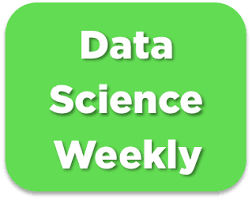

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [24]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix,classification_report
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [25]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [26]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [27]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [28]:
data_sample.info()

display(data_sample.describe())

display(data_sample.country.value_counts())
display(data_sample.source.value_counts())
data_sample.converted.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 7143 to 10831
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              10000 non-null  object
 1   age                  10000 non-null  int64 
 2   new_user             10000 non-null  int64 
 3   source               10000 non-null  object
 4   total_pages_visited  10000 non-null  int64 
 5   converted            10000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 546.9+ KB


,age,new_user,total_pages_visited,converted
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,30.454300,0.686800,4.840700,0.031500
std,8.155904,0.463818,3.329479,0.174673
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,70.000000,1.000000,27.000000,1.000000


country
US         5629
China      2457
UK         1515
Germany     399
Name: count, dtype: int64

source
Seo       4876
Ads       2846
Direct    2278
Name: count, dtype: int64

converted
0    9685
1     315
Name: count, dtype: int64

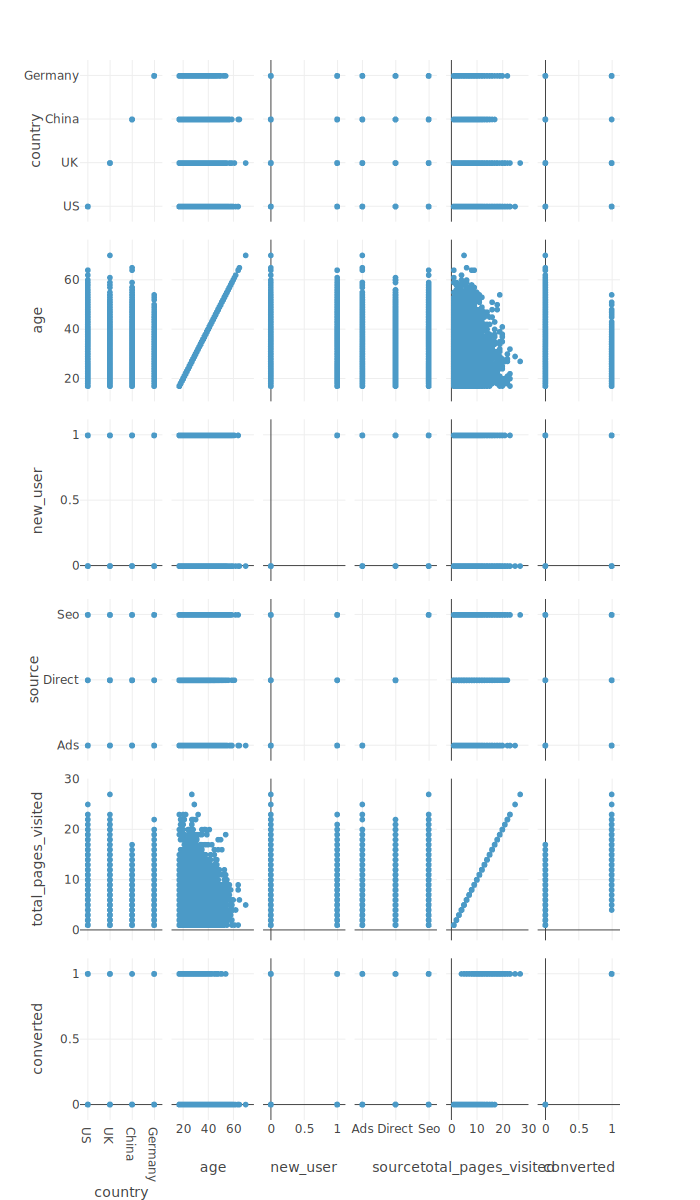

In [29]:
fig=px.scatter_matrix(data_sample,width=700,height=1200)
fig.show()

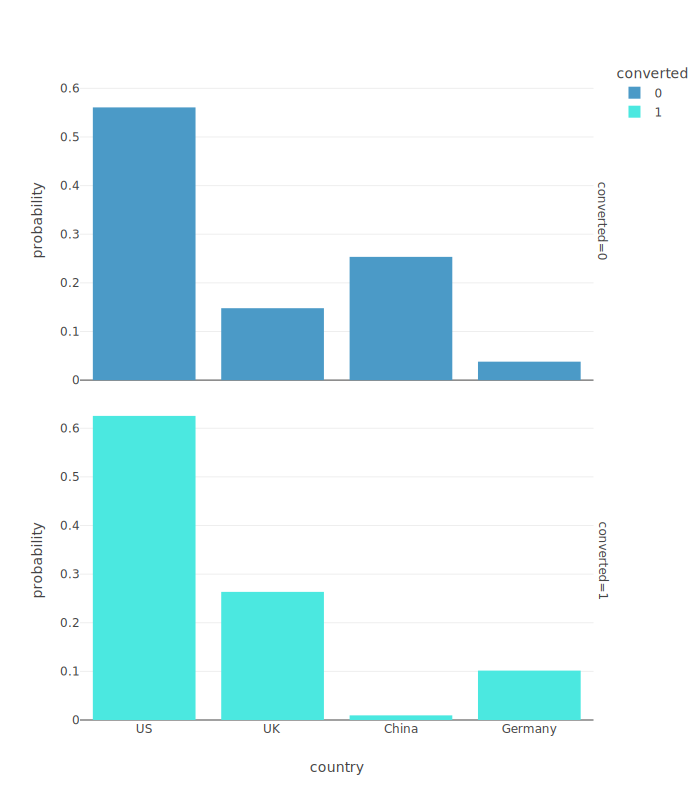

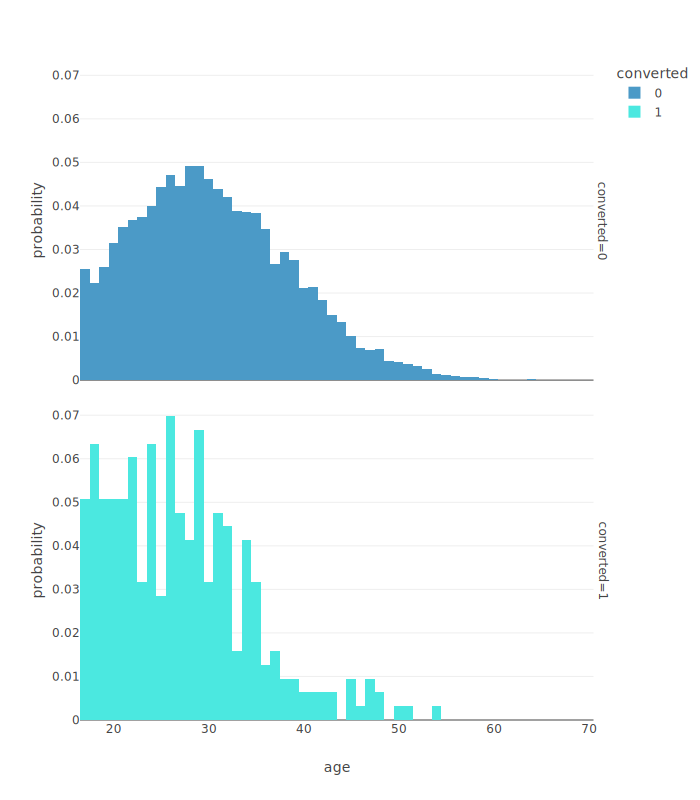

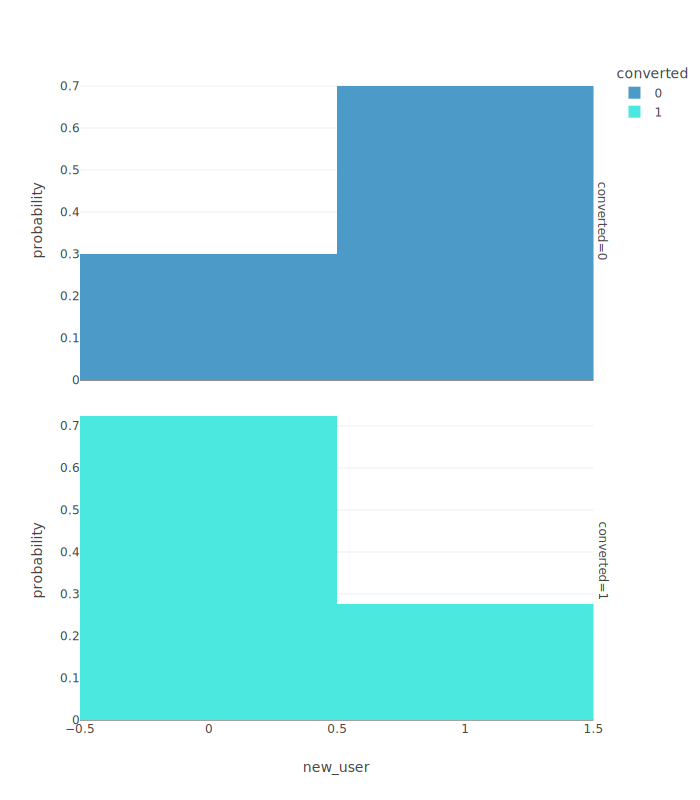

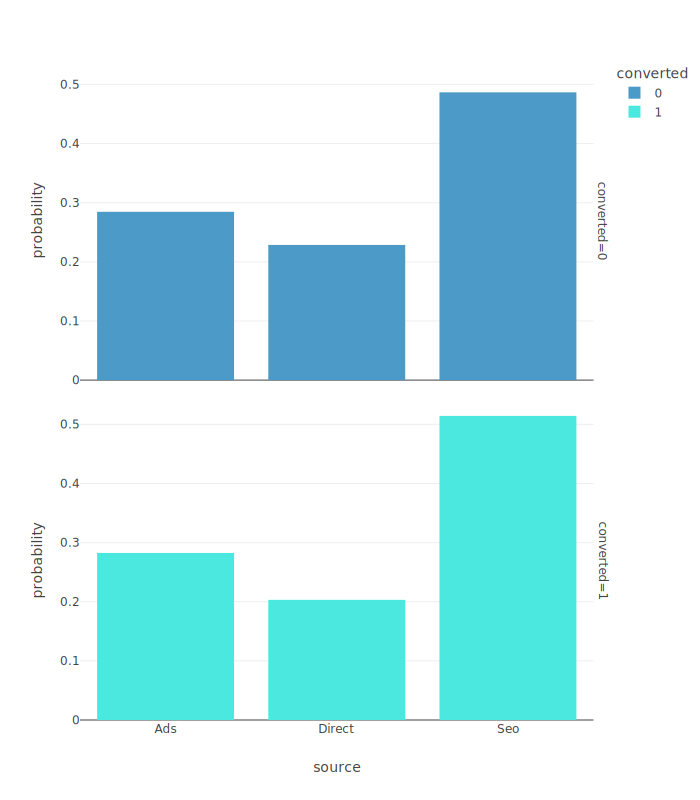

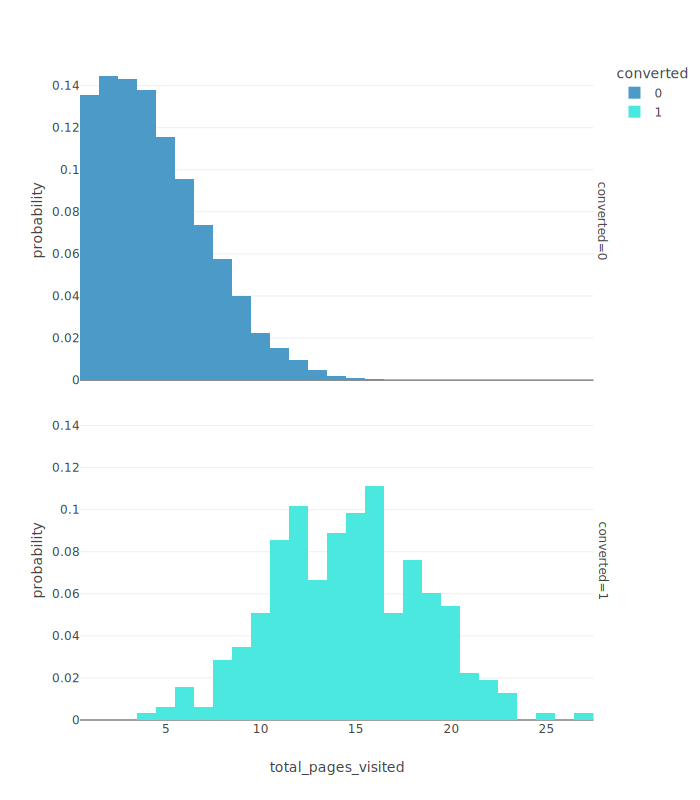

In [30]:
num_features = data_sample.drop('converted',axis=1)
for f in num_features:
    fig = px.histogram(
        data_sample, f, color="converted", facet_row="converted", histnorm="probability",width=700,height=800
    )
    fig.show()

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [31]:
print("Separating labels from features...")
target_variable = "converted"

X = data.drop(target_variable, axis = 1)
Y = data.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  age  new_user  source  total_pages_visited
0    China   22         1  Direct                    2
1       UK   21         1     Ads                    3
2  Germany   20         0     Seo                   14
3       US   23         1     Seo                    3
4       US   28         1  Direct                    3


In [32]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0,stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [34]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [35]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

numeric_indices=['age','new_user','total_pages_visited']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_indices=['country','source']
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_indices),
        ('cat', categorical_transformer, categorical_indices)
    ])

Encoding categorical features and standardizing numerical features...


In [36]:
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5])
print()


print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) 
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited
178877   China   23         0  Direct                    2
215523   China   28         0     Ads                    2
73318    China   30         1     Seo                    7
58164       UK   37         1     Seo                    3
234640      US   31         1     Ads                    8
...Done.
[[-0.91458053 -1.4767432  -0.85939501  0.          0.          0.
   1.          0.        ]
 [-0.30994956 -1.4767432  -0.85939501  0.          0.          0.
   0.          0.        ]
 [-0.06809718  0.67716581  0.63639894  0.          0.          0.
   0.          1.        ]
 [ 0.77838618  0.67716581 -0.56023622  0.          1.          0.
   0.          1.        ]
 [ 0.05282902  0.67716581  0.93555773  0.          0.          1.
   0.          0.        ]]

Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited
269237   China   24         

In [37]:
# Train model
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [39]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)


Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]


## Performance assessment

In [40]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7640795553472176
f1-score on test set :  0.7610405323653963


In [41]:
Y_test_pred = classifier.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27540
           1       0.86      0.69      0.76       918

    accuracy                           0.99     28458
   macro avg       0.92      0.84      0.88     28458
weighted avg       0.99      0.99      0.99     28458



In [47]:
feature_names = data.columns.drop('converted')
coef = classifier.coef_

for i, class_coef in enumerate(coef):
    print(f"Coefficients for class {i}:")
    for feature_name, coef_value in zip(feature_names, class_coef):
        print(f"{feature_name}: {coef_value}")


Coefficients for class 0:
country: -0.6093890686994382
age: -0.7922005508818437
new_user: 2.5452737318092145
source: 3.612320669687816
total_pages_visited: 3.4157074166306733


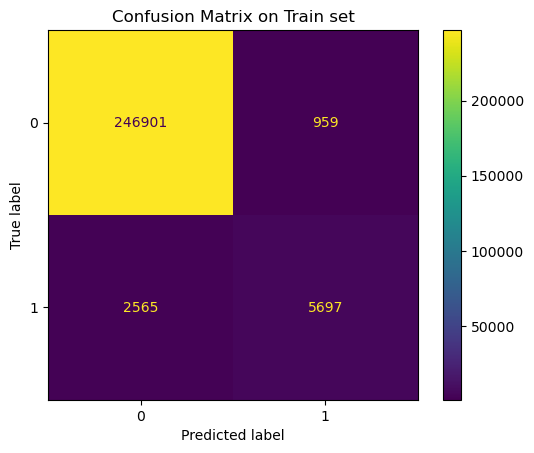

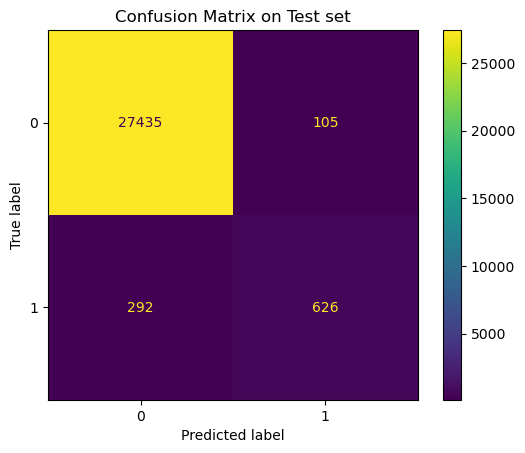

In [36]:
# You can also check more performance metrics to better understand what your model is doing
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [47]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

LogisticRegression()

In [48]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to arrays before using scikit-learn
print("Convert pandas DataFrames to arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to arrays...
...Done
[[16]
 [ 5]
 [ 1]
 [ 6]
 [ 3]]


In [49]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[15.99230155]
 [ 4.99841758]
 [ 1.0006416 ]
 [ 5.99786158]
 [ 2.99952959]]


In [50]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**